In [25]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [26]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [27]:
np.random.seed(1773)

In [28]:
CSV_PATH = "/home/ubuntu/auto/dataset/train.csv"
df = pd.read_csv(CSV_PATH)

In [29]:
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
SIZE = 255
BS = 64
GPU = 0
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
print(EXP_NAME)

64-255-2020-04-04_13:53:00


In [30]:
item_tfms = [Resize(SIZE)]

In [31]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/auto/dataset/train", 
                                item_tfms=item_tfms, valid_pct=2.0,
                                bs=BS, num_workers=16, device=GPU)

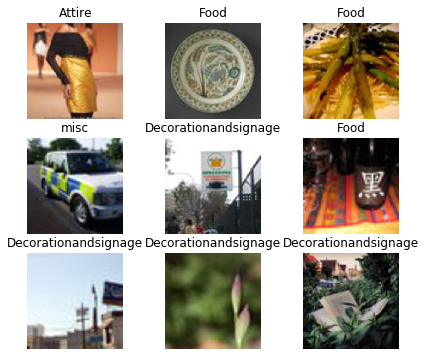

In [32]:
dls.show_batch(max_n=9, figsize=(7,6))

In [33]:
print(dls.vocab)
len(dls.vocab),dls.c

(#4) ['Attire','Decorationandsignage','Food','misc']


(4, 4)

In [34]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=4)
learn = Learner(dls, model, metrics=[error_rate, accuracy], opt_func=ranger, cbs= MixUp())

Loaded pretrained weights for efficientnet-b3


In [35]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.023398,None,None,None,00:36


/home/ubuntu/miniconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.770595,None,None,None,00:36
1,0.695298,None,None,None,00:36
2,0.646153,None,None,None,00:36
3,0.624462,None,None,None,00:36
4,0.612485,None,None,None,00:36
5,0.602617,None,None,None,00:36
6,0.572655,None,None,None,00:36
7,0.566561,None,None,None,00:36
8,0.533128,None,None,None,00:36
9,0.527890,None,None,None,00:36


In [36]:
learn.freeze()
learn.fit_sgdr(2,5, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.444958,None,None,None,00:36
1,0.454142,None,None,None,00:36
2,0.450351,None,None,None,00:36
3,0.433740,None,None,None,00:36
4,0.437118,None,None,None,00:36
5,0.467416,None,None,None,00:36
6,0.473435,None,None,None,00:36
7,0.476014,None,None,None,00:36
8,0.460960,None,None,None,00:36
9,0.446593,None,None,None,00:36


In [37]:
learn.unfreeze()
learn.fit_sgdr(2,5, slice(2e-7, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.413462,None,None,None,00:36
1,0.411427,None,None,None,00:36
2,0.411891,None,None,None,00:36
3,0.416472,None,None,None,00:36
4,0.419351,None,None,None,00:36
5,0.410823,None,None,None,00:36
6,0.426923,None,None,None,00:36
7,0.421445,None,None,None,00:36
8,0.420799,None,None,None,00:36
9,0.413852,None,None,None,00:36


In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)
interp.most_confused(min_val=10)

IndexError: list index out of range

In [ ]:
path = "/home/ubuntu/auto/dataset/test"
imgs = get_image_files(path)
test_dl = dls.test_dl(imgs)

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
ids = [i for i in os.listdir(path)]
submission = pd.DataFrame({'Image': ids, 'Attire': preds[:,0], 'Decorationandsignage': preds[:,1], 'Food': preds[:,2], 'misc': preds[:,2]})

In [ ]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [ ]:
sub = submission.drop("Image", axis=1)

In [ ]:
id_class = sub.idxmax(axis=1).tolist()

In [ ]:
submission = pd.DataFrame({'Image': ids, 'Class': id_class})

In [ ]:
submission.head()

In [ ]:
submission.to_csv('/home/ubuntu/auto/submission/{}.csv'.format(EXP_NAME), index=False)